In [2]:
## import numpy as np # linear algebra
from matplotlib import pyplot as plt
#We need these in this file:
import sys
sys.path.append('cropping')
sys.path.append('scripts')
import load_read_name_extractor as lrne
import SVM_classifier_general as svm_general

#Taget fra længere nede i koden:
import torch
from torchvision import transforms
from PIL import Image
import random
import itertools
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import DeepFunctions as df
from random import shuffle
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from IPython.display import display
import os
import json
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Call the function to list GPU names
df.list_gpu_names()
#R
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

Number of available GPUs: 4
GPU 0: NVIDIA TITAN X (Pascal)
GPU 1: NVIDIA TITAN X (Pascal)
GPU 2: NVIDIA TITAN X (Pascal)
GPU 3: NVIDIA TITAN X (Pascal)
cuda:2


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,stride=1):
        super(ResidualBlock, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (identity mapping)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Add the shortcut connection
        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [5]:
kernel_size = 3
kernel_size1 = 3
padding = 0
# define network
conv1toconv2 = 16
conv2toconv3 = 32
conv3toconv4 = 64
conv4toconv5 = 128
conv5tores1 = 256
res1tores2 = 256
res2tores3 = 256
res3tores4 = 256
res4tores5 = 256
res5tores6 = 256
res6tolin1 = 256
lin = 256
momentum = 0.1

class NeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, conv1toconv2, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(conv1toconv2)
        self.conv2 = nn.Conv2d(conv1toconv2, conv2toconv3, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(conv2toconv3)
        self.conv3 = nn.Conv2d(conv2toconv3, conv3toconv4, kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(conv3toconv4)
        self.conv4 = nn.Conv2d(conv3toconv4, conv4toconv5, kernel_size, padding=padding)
        self.bn4 = nn.BatchNorm2d(conv4toconv5)
        self.conv5 = nn.Conv2d(conv4toconv5, conv5tores1, kernel_size, padding=padding)
        self.bn5 = nn.BatchNorm2d(conv5tores1)
        
        self.residual1 = ResidualBlock(conv5tores1, res1tores2)
        self.residual2 = ResidualBlock(res1tores2, res2tores3)
        self.residual3 = ResidualBlock(res2tores3, res3tores4)
        self.residual4 = ResidualBlock(res4tores5, res4tores5)
        self.residual5 = ResidualBlock(res4tores5, res5tores6)
        self.residual6 = ResidualBlock(res5tores6, res6tolin1)
        
        self.pool = nn.AvgPool2d(2, 2)
        self.poolmax = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(6 * res6tolin1, lin)
        self.bn7 = nn.BatchNorm1d(lin)
        self.FC2 = nn.Linear(lin,lin)
        self.bn8 = nn.BatchNorm1d(lin)
        self.FC3 = nn.Linear(lin, num_classes)
        self.bn9 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print(x.shape)
        x = self.poolmax(x)
        
        #print(x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        #print(x.shape)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
                                  
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.residual3(x)
        x = self.residual4(x)
        x = self.residual5(x)
        x = self.residual6(x)
        
        x = self.pool(x)
        
        x = self.flatten(x)
        x = self.FC1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.FC2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.FC3(x)
        return x

In [6]:
trainDataloader = torch.load('data/train_loader.pth')
valDataloader = torch.load('data/val_loader.pth')
testDataloader = torch.load('data/test_loader.pth')
lenthdataset = torch.load('data/lengthsdataset.pth')

In [15]:
dist = [0] * 10
def dist(dataloader)
    for i, data in enumerate(dataloader, 0):
        # Get the inputs and labels
        inputs, labels = data
        for lodg in labels:
            dist[int(lodg)] += 1
print(dist)

[1201, 1326, 868, 870, 664, 540, 775, 890, 306, 0]


In [6]:
num_classes = 9
bestnet = NeuralNetwork()


path_model = "models/best_model_stateAcc0.757epoch111.0.pt"
bestnet.load_state_dict(torch.load(path_model))
bestnet.to(device)

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual1): ResidualBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU

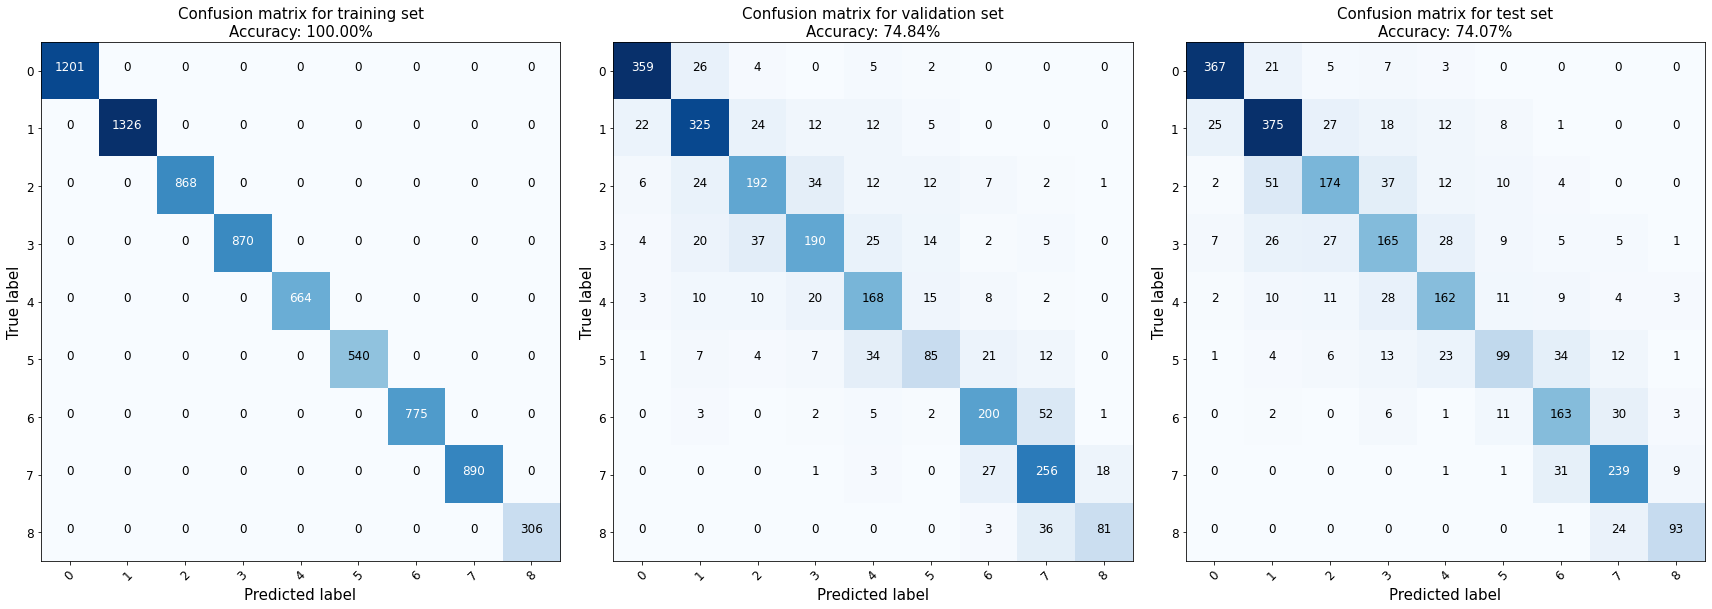

In [7]:
cm1, acc1 = df.create_confusion_matrix(trainDataloader, bestnet, device=device)
title1 = 'Confusion matrix for training set'

cm2, acc2 = df.create_confusion_matrix(valDataloader, bestnet, device=device)
title2 = 'Confusion matrix for validation set'

cm3, acc3 = df.create_confusion_matrix(testDataloader, bestnet, device=device)
title3 = 'Confusion matrix for test set'

df.plot_3_confusion_matrices(cm1, cm2, cm3, acc1, acc2, acc3, num_classes, title1, title2, title3)

In [8]:
path_result = "results/0.0008_0_7_0.1_0.4_75.73%_results.json"
with open(path_result, 'r') as file:
    data = json.load(file)
# Now 'data' contains the content of the JSON file
trainLossList = data['train']['loss']
trainAccList = data['train']['accuracy']
valLossList = data['validation']['loss']
valAccList = data['validation']['accuracy']

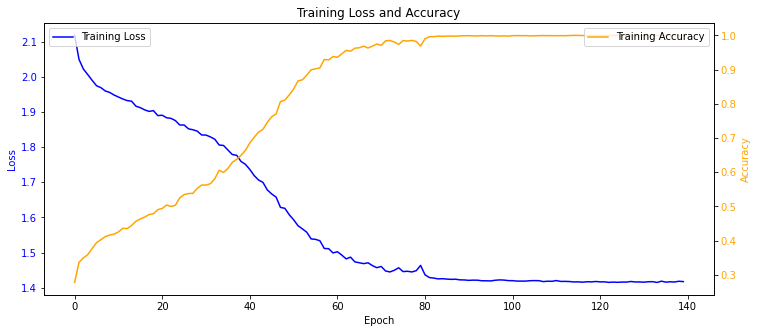

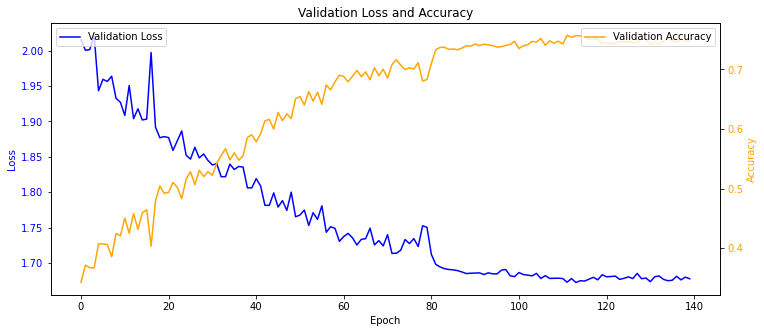

In [9]:
df.plot_loss_and_accuracy(df.transfer_to_cpu(trainLossList), df.transfer_to_cpu(trainAccList), df.transfer_to_cpu(valLossList), df.transfer_to_cpu(valAccList))

In [10]:
lenthdataset[1]

2480

In [11]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(trainLossList, trainAccList, valLossList, valAccList):
    # Create a single subplot with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot training loss and validation loss on the same axes
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='blue')
    ax1.plot(trainLossList, label='Training Loss', color='blue')
    ax1.plot(valLossList, label='Validation Loss', color='dodgerblue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='orange')

    # Plot training accuracy and validation accuracy on the second axes
    ax2.plot(trainAccList, label='Training Accuracy', color='darkorange')
    ax2.plot(valAccList, label='Validation Accuracy', color='coral')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Combine legends into a single legend at the middle left with the specified order
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    combined_lines = lines + lines2
    combined_labels = labels + labels2
    order = [2, 3, 0, 1]  # Train Accuracy, Val Accuracy, Train Loss, Val Loss
    ax1.legend([combined_lines[i] for i in order], [combined_labels[i] for i in order], loc='center left')

    plt.title('Training and Validation Loss/Accuracy')
    plt.show()

# Example usage:
# plot_loss_and_accuracy(train_loss, train_acc, val_loss, val_acc)


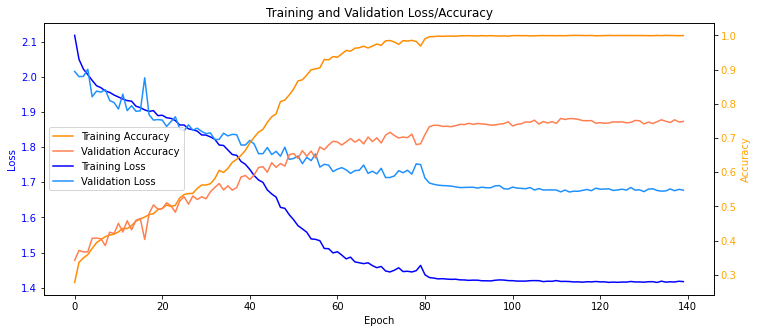

In [12]:
plot_loss_and_accuracy(df.transfer_to_cpu(trainLossList), df.transfer_to_cpu(trainAccList), df.transfer_to_cpu(valLossList), df.transfer_to_cpu(valAccList))